# Подбор тарифа для клиентов оператора мобильной связи

<div style="border:solid rebeccapurple 2px; padding: 20px;>
    
<font color='rebeccapurple'>Привет, Андрей!<br>
Прежде всего хочу выразить благодарность за время и внимание, уделённые проверке моего проекта, а также за все рекомендации по его улучшению. Я их все внимательно изучил, проработал и дал свои комментарии.
</font>

</div>

Оператору мобильной связи «Мегалайн» необходимо перевести клиентов с архивных тарифных планов. Для этого предполагается построение модели для задачи классификации, которая проанализирует поведение клиентов и предложит им один из двух новых тарифных планов: `«Смарт»` или `«Ультра»`.

**Задача исследования** - на основе имеющихся данных о поведении клиентов, которые уже перешли на данные тарифные планы, построить модель, которая выберет подходящий тариф для тех пользователей, которые продолжают пользоваться архивными тарифами.

По условию задания необходимо получить модель, доля правильных ответов которой, составит не менее 0.75.

**Описание имеющихся данных**

* **Датасет из файла** **`users_behavior.csv`** (каждый объект в наборе данных - это информация о поведении одного пользователя за месяц):
    * `сalls` —  количество звонков;
    * `minutes` — суммарная длительность звонков в минутах;
    * `messages` — количество sms-сообщений;
    * `mb_used` — израсходованный интернет-трафик в Мб;
    * `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).
    

О данных известно, что они не нуждаются в предобработке.

Исследование будет проведено в пять этапов:
1. Обзор данных.
2. Изучение и предобработка данных.
3. Построение моделей.
4. Проверка модели на вменяемость.
5. Общие выводы.

## Обзор и изучение данных

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


# чтение из файла
df = pd.read_csv('/datasets/users_behavior.csv')

### Обзор данных

Посмотрим на общий вид данных, сводную информацию по ним, проверим количество пропущенных значений и наличие дубликатов, чтобы убедиться, что данные действительно не нуждаются в предобработке.

In [2]:
# вывод первых строк данных из файла
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
# просмотр сводной информации о данных из файла
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
# проверка данных на пропуски
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [5]:
# проверка на полные дубликаты в данных
print('Количество полных дублированных строк:', df.duplicated().sum())

Количество полных дублированных строк: 0


### Выводы по обзору данных

* Данные успешно загружены и проанализированы. Таблица содержит `3214` записей, пропущенных значений, полных дубликатов и нарушений стиля заголовков в данных нет.
* Тип данных для количественных признаков `calls` (количество звонков), `minutes` (суммарная длительность звонков), `messages ` (количество sms-сообщений) и `mb_used` (израсходованный интернет-трафик) соотвествует `float64`. Для всех этих данных, кроме `minutes` и `mb_used` изменим тип данных на `int64`, так как количество звонков и сообщений измеряется в целых единицах.
* Тип данных категориального признака `is_ultra` (каким тарифом пользовался клиент в течение месяца) соотвествует `int64` и, как следует из описания, принимает значение равное `0` для тарифа `Смарт` и `1` для тарифа `Ультра`.
* Несмотря на то, что в задании заявлено об отсуствии необходимости предобработки, всё же проведём её в минимальном виде - изменим типы данных для количества звонков и сообщений.

## Изучение и предобработка данных

### Изменение типов данных

Значения `calls` и `messages` приведём к целочисленному типу, проверим данные на полные дубликаты и посмотрим на основные описательные статистики.

In [6]:
# изменение типа данных для количества звонков calls и сообщений messages с float64 на int64
df[['calls', 'messages']] = df[['calls', 'messages']].astype('int64')

Проверим полученный результат, вызвав метод info().

In [7]:
# просмотр сводной информации о датафреме после смены типа данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


* Тип данных для количества звонков `calls` и сообщений `messages` успешно изменён с `float64` на `int64`.

### Изучение данных

Изучим все количественные данные из таблицы. Для этого посмотрим на их основные описательные статистики и посмотрим на графики распределения частот по этим признакам, постром для них графики размаха, чтобы оценить наличие аномальных значений.

In [8]:
# просмотр описательных статистик по основным показателям
df[['calls', 'minutes', 'messages', 'mb_used']].describe()

,calls,minutes,messages,mb_used
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836
std,33.236368,234.569872,36.148326,7570.968246
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500
50%,62.000000,430.600000,30.000000,16943.235000
75%,82.000000,571.927500,57.000000,21424.700000
max,244.000000,1632.060000,224.000000,49745.730000


По всем признакам медианные и средние значения отличаются незначительно. Сильного смещения в данных нет. Посмотрим на распределения данных с помощью гистограмм частот и диаграмм размаха. Для этого создадим вспомогательную функцию *pair_chart()*.

In [9]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def pair_chart(data, column_name):
    """
    input: data (pandas.Series)   - данные для построения гистограммы и диаграммы размаха
           column_name (str)      - наименование столбца данных
    output: None
    description: Функция для построения парных графиков для исследуемого параметра:
                 - Первый график гистограмма - отображает распределение частот с помощью параметра stat=frequency
                 - Второй график диаграмма размаха - отображает максимальные границы выборки и выбросы в данных
    """
    
    labels = {'calls': 'Количество звонков',
              'minutes': 'Длительность звонков, мин',
              'messages': 'Количество sms-сообщений',
              'mb_used': 'Израсходованный интернет-трафик, Мб',
              'accuracy': 'Точность'
             }

    sns.set()
    sns.set_palette(palette='CMRmap')
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    axes[0].set_title(labels[column_name] + '. Гистограмма частот.', fontsize=14)
    axes[0].set_ylabel('Количество', fontsize = 13)
    axes[0].set_xlabel(labels[column_name], fontsize = 13)
    sns.histplot(data, bins=25, alpha=0.5, kde=True, ax=axes[0], stat='frequency')
    
    axes[1].set_title(labels[column_name] + '. Диаграмма размаха.', fontsize=14)
    axes[1].set_xlabel('', fontsize=13)
    sns.boxplot(x=data, orient='h', ax=axes[1], palette='BuPu')
    
    plt.show();

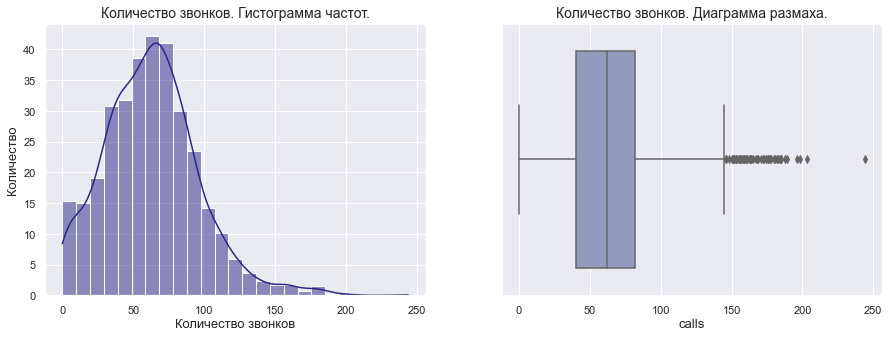

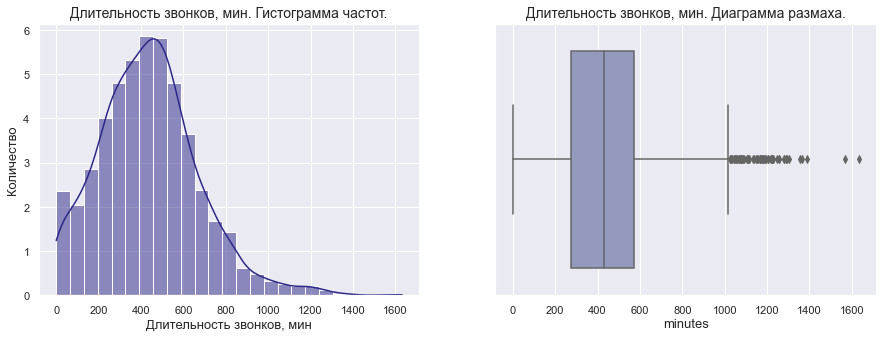

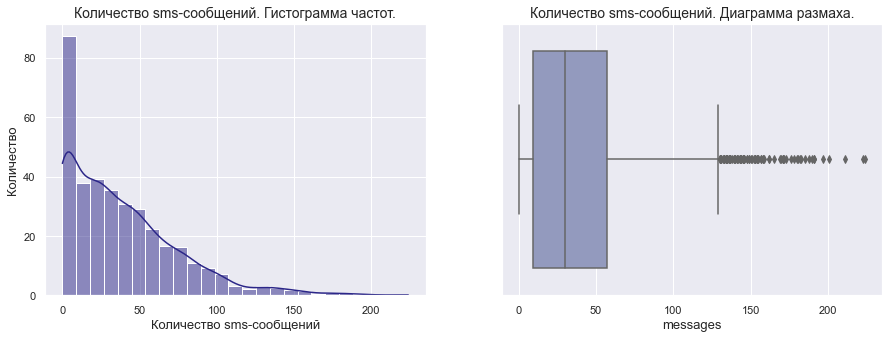

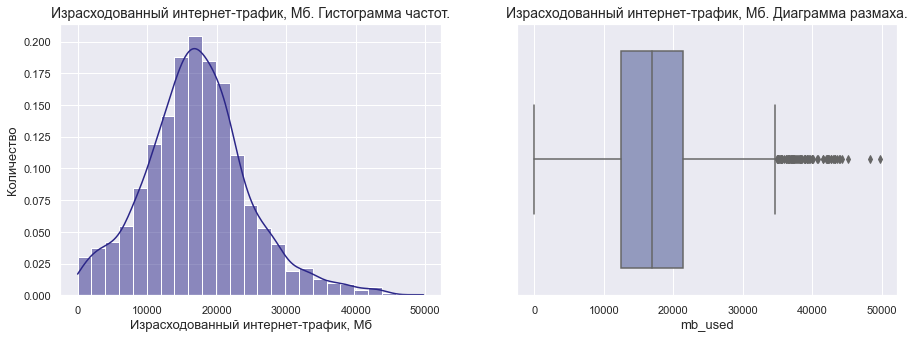

In [10]:
# построение соотвествующих графиков для значений из столбцов 'calls', 'minutes', 'messages', 'mb_used'
for column in df[['calls', 'minutes', 'messages', 'mb_used']].columns:
    pair_chart(df[column], column)

Согласно диаграмм размаха все данные имеют выбросы, находящиеся за правой границей, то есть в областях максимальных значений. Оценим долю выбросов по отношению к всем имеющимся данным. Для этого создадим пару вспомогательных функций:
* `outliers_value()` - для определения границы, за которой будут находится выбросы;
* `outliers_rate()` - определения количества и доли выбросов по отношению ко всем данным.

In [11]:
# вспомогательная функция для определения границы выбросов
def outliers_value(column_name):
    """
    input: column_name (str)      - название столбца (параметра, для которого будет определяться граница)
    output: val        (float)    - значение верхней границы, за которой будут находится выбросы
    description: Функция находит и возвращает значение границы для исследуемого параметра за которой будут находится выбросы
    """
    val = df[column_name].describe()['75%'] + (df[column_name].describe()['75%'] - df[column_name].describe()['25%']) * 1.5
    return val

In [12]:
# пустой словарь для последующего хранения значений выбросов по ключам в виде имён параметров
max_vals = {}

# сохранение значений границ выбросов в словарь max_vals с помощью функции outliers_value()
for column in df[['calls', 'minutes', 'messages', 'mb_used']].columns:
    max_vals[column] = outliers_value(column)

In [13]:
# вспомогательная функция для определения количества и доли выбросов
def outliers_rate(column_name, max_vals=max_vals):
    """
    input: column_name (str)      - название столбца (параметра, для которого будут находится количество и доля выбросов)
           max_vals (dict)        - словарь с границами выбросов
    output: вывод на печать с помощью print() значения количества и доли выбросов
    description: Функция расчитывает и выводит на печать значения количества и доли выбросов по отношению ко всем данным
    """
    outliers_count = df.loc[df[column] > max_vals[column]].shape[0]
    rate = round(outliers_count / df.shape[0]  * 100, 2)
    print(f'Количество выбросов для параметра «{column_name}» равно: {outliers_count} ({rate}%)')

In [14]:
for column in df[['calls', 'minutes', 'messages', 'mb_used']].columns:
    outliers_rate(column)

Количество выбросов для параметра «calls» равно: 62 (1.93%)
Количество выбросов для параметра «minutes» равно: 61 (1.9%)
Количество выбросов для параметра «messages» равно: 91 (2.83%)
Количество выбросов для параметра «mb_used» равно: 77 (2.4%)


Посмотрим на соотношение классов целевого признака.

In [15]:
# подсчёт долей каждого из классов целевого признака по отношению ко всем данным
target_rate = df['is_ultra'].value_counts() / df.shape[0]
target_rate.index = ['0 - «Смарт»', '1 - «Ультра»']
target_rate

0 - «Смарт»     0.693528
1 - «Ультра»    0.306472
Name: is_ultra, dtype: float64

Для наглядности отобразим соотношение классов в целевом признаке на графике.

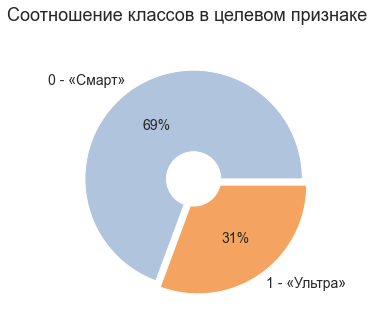

In [16]:
# построение круговой диаграммы для отображения соотношения классов в целевом признаке
colors = ['lightsteelblue', 'sandybrown']

fig = plt.figure(figsize = (7, 5))
fig.suptitle('Соотношение классов в целевом признаке', fontsize=18)
plt.pie(
    target_rate,
    labels = target_rate.index,
    autopct='%.0f%%',
    textprops={'fontsize': 14},
    colors=colors,
    explode=(0, 0.07)
)
centre_circle = plt.Circle((0,0),0.25,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show();

### Выводы по обзору данных

* Типы данных для `calls` и `messages` приведены к целочисленному типу `int64` в соотвествии с хранимой в них информацией.
* Все данные обладают незначительным скосом вправо. В данных по количеству sms-сообщений много нулевых значений.
* Параметр `calls` содержит `62` выброса (`1.93%`), параметр `minutes` содержит `61` выброс (`1.9%`), параметр `messages` содержит `91` выброс (`2.83%`), параметр `mb_used` содержит `77` выбросов (`2.4%`). Выбросы оставлены как есть.
* Соотношение классов в целевом признаке распределено следующим образом:
    * `класс 0` (тарифный план `«Смарт»`) - `69.4%` данных;
    * `класс 1` (тарифный план `«Ультра»`) - `30.6%` данных.
* Так как объектов меньшего класса более `10%`, то исследуемую выборку можно считать сбалансированной.

## Построение моделей

Так как целевой признак `is_ultra` - каким тарифом пользовался клиент в течение месяца соотвествует одному из двух фиксированных значений (`«Ультра»` — 1, `«Смарт»` — 0), то предстоит решать задачу бинарной классификации. Для её решения попробуем следующие модели и алгоритмы с подстройкой гиперпараметров:
* Решающее дерево `DecisionTreeClassifier()`;
* Случайный лес `RandomForestClassifier()`;
* Логистическая регрессия `LogisticRegression()`.

### Разбиение выборки на обучающую и проверочные части

Из исходного датасета выделим обучающие и целевой признаки в переменные `features` и `target` соотвественно. В качестве `target` будет выступать столбец с категориальным признаком `is_ultra`. В `features` будут находится все остальные столбцы.

In [17]:
# разделение выборки на обучающие и целевой признаки
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Зафиксируем псевдослучайность единым начальным значением, которое будет использовано в дальнейшем во всех расчётах, чтобы обеспечить воспроизводимость полученных результатов.

In [18]:
# сохраним случайное состояние (число) в переменную rnd
rnd = 123

Разделим исходные данные на три части: обучающую, валидационную и тестовую в соотношении 3:1:1 (60% данных составит обучающая часть и по 20% валидационная и тестовая).

In [19]:
# выделение тестовой выборки и сохрание оставшейся части для последующего разделения
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rnd)

# разделение оставшейся части на обучающую и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=rnd)

Проверка размеров полученных частей. 

In [20]:
# размер обучающей части
features_train.shape, target_train.shape

((1928, 4), (1928,))

In [21]:
# размер валидационной части
features_valid.shape, target_valid.shape

((643, 4), (643,))

In [22]:
# размер тестовой части
features_test.shape, target_test.shape

((643, 4), (643,))

* Разбиение проведено корректно в соотвествии с первоначально намеченным соотношением 3:1:1.

Проверим соотношение классов целевого признака в тренировочной, валидационной и тестовой частях, полученных из исходного датафреймаю

In [23]:
# определение соотношения классов в тренировочной части
target_train.value_counts() / target_train.shape[0]

0    0.694502
1    0.305498
Name: is_ultra, dtype: float64

In [24]:
# определение соотношения классов для валидационной части
target_valid.value_counts() / target_valid.shape[0]

0    0.684292
1    0.315708
Name: is_ultra, dtype: float64

In [25]:
# определение соотношения классов для тестовой части
target_test.value_counts() / target_test.shape[0]

0    0.699844
1    0.300156
Name: is_ultra, dtype: float64

* Разбиение исходного датафрейма на тренировочную, валидационную и тестовую части практически не повлияло на соотношение классов целевого признака в полученных из исходного датафрема частях.

### Решающее дерево

Обучим модель решающего дерева. Так как алгоритм достаточно слабый, то много усилий подборке значений гиперпараметров для него уделять не будем и попробуем улучшить качество модели настройкой лишь одного гиперпараметра `max_depth` - максимальной глубины дерева.

In [26]:
# обучение модели решающего дерева с подстрокой гиперпараметра max_depth - глубины дерева
best_dt_model = None
best_dt_result = best_depth = 0

for depth in range(1, 21):
    dt_model = DecisionTreeClassifier(random_state=rnd, max_depth=depth)
    dt_model.fit(features_train, target_train)
    predictions = dt_model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)

    if result > best_dt_result:
        best_dt_model = dt_model
        best_dt_result = result
        best_depth = depth

print(f'Лучший результат для решающего дерева {round(best_dt_result, 3)} при глубине {best_depth}')

Лучший результат для решающего дерева 0.795 при глубине 9


Проверим какую точность `accuracy` покажет полученная модель на основе решающего дерева на тестовой выборке.

In [27]:
# проверка точности модели на основе решающего дерева на тестовой выборке
predictions = best_dt_model.predict(features_test)
dt_result = accuracy_score(target_test, predictions)
print(f'Точность (accuracy) модели на основе решающего дерева на тестовой выборке: {round(dt_result, 3)}')

Точность (accuracy) модели на основе решающего дерева на тестовой выборке: 0.787


* Точность даже такого достаточно слабого, склонного к переобучению, алгоритма машинного обучения как решающее дерево, на тестовой выборке составила `0.787`, что уже удовлетворяет условиям задания. Посмотрим насколько можно улучшить результаты обучением модели на других алгоритмах.

### Случайный лес

Случайный лес является более сильным алгоритмом по сравнению с единичным решающим деревом. Поэтому, уделим больше внимания подстройке гиперпараметров данной модели. Для настройки выделим следующие гиперпараметры:
* `n_estimators` - количество деревьев;
* `max_depth` - максимальная глубина каждого дерева;
* `criterion` - тип функции для измерения качества разделения;
* `min_samples_split` - минимальное количество примеров для разделения;
* `min_samples_leaf` - минимальное количество объектов в листе.

В процессе подстройки гиперпараметров выберем модель, которая обеспечить лучшую точность `accuracy` на валидационной выборке.

In [72]:
%%time
# обучение модели случайного леса с подстрокой различных гиперпараметров
best_rf_model = None
best_rf_result = 0

for est in range(50, 55, 2):
    for depth in range (7, 10):
        for crit in ['gini', 'entropy']:
            for min_split in range(2, 4):
                for min_leaf in range(3, 5):
                    rf_model = RandomForestClassifier(
                        random_state=rnd,
                        n_estimators=est,
                        max_depth=depth,
                        criterion=crit,
                        min_samples_split=min_split,
                        min_samples_leaf=min_leaf,
                        n_jobs=-1
                    )
                    
                    rf_model.fit(features_train, target_train)
                    predictions = rf_model.predict(features_valid)
                    result = accuracy_score(target_valid, predictions)
                    
                    if result > best_rf_result:
                        best_rf_model = rf_model
                        best_rf_result = result
            
print(f'Лучший результат для случайного леса {round(best_rf_result, 3)}\n ')
print(f'Лучший результат получен на модели с параметрами \n{best_rf_model.get_params()}\n')

Лучший результат для случайного леса 0.81
 
Лучший результат получен на модели с параметрами 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 52, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

CPU times: total: 9.31 s
Wall time: 3.81 s


Проверим какую точность `accuracy` покажет полученная модель на основе случайного леса на тестовой выборке.

In [29]:
# проверка точности модели на основе случайного леса на тестовой выборке
predictions = best_rf_model.predict(features_test)
rf_result = accuracy_score(target_test, predictions)
print(f'Точность (accuracy) модели на основе случайного леса на тестовой выборке: {round(rf_result, 3)}')

Точность (accuracy) модели на основе случайного леса на тестовой выборке: 0.816


* Использованием более сильного алгоритма машинного обучения, такого как случайный лес, удалось повысить значение точности до `0.816`, но при этом также заметно возрасло время обучения модели, которое занимает процесс перебора гиперпараметров.

In [73]:
%%time
from sklearn.model_selection import GridSearchCV


clf = RandomForestClassifier(random_state=rnd, n_jobs=-1)

params_grid = {
    'max_depth': range(7, 10),
    'n_estimators': range(50, 55, 2),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(3, 5),
   }

clf_grid = GridSearchCV(estimator=clf, param_grid=params_grid, scoring='accuracy')
clf_grid.fit(features_train, target_train)
best_clf = clf_grid.best_estimator_

print(f'Лучший результат для случайного леса {round(clf_grid.best_score_, 3)}\n ')
print(f'Лучший результат получен на модели с параметрами \n{best_clf.get_params()}\n')

Лучший результат для случайного леса 0.811
 
Лучший результат получен на модели с параметрами 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

CPU times: total: 15.1 s
Wall time: 14.8 s


### Логистическая регрессия

Также проверим результат точности `accuracy`, который можено получить на такой модели как логистическая регрессия. В качестве гиперпараметра будем менять `solver` - алгоритм, используемый для решения задачи оптимизации, выбирая его из двух значений `liblinear` и `lbfgs`.

In [30]:
# обучение модели модели логистической регрессии с подстройкой гиперпараметра в виде выбора алгоритма оптимизации
best_reg_model = None
best_reg_result = 0

solvers = ['liblinear', 'lbfgs']
for solver in solvers:
    reg_model = LogisticRegression(random_state=rnd, solver=solver)
    reg_model.fit(features_train, target_train)
    predictions = reg_model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    
    if result > best_reg_result:
        best_solver = solver
        best_reg_result = result
        best_reg_model = reg_model
            
print(f'Лучший результат для логистической регрессии {round(best_reg_result, 3)} на алгоритме «{best_solver}»')

Лучший результат для логистической регрессии 0.734 на алгоритме «lbfgs»


Проверим какую точность `accuracy` покажет полученная модель на основе логистической регрессии на тестовой выборке.

In [31]:
# проверка точности модели на основе логистической регрессии на тестовой выборке
predictions = best_reg_model.predict(features_test)
reg_result = accuracy_score(target_test, predictions)
print(f'Точность (accuracy) модели на основе логистической регрессии на тестовой выборке: {round(reg_result, 3)}')

Точность (accuracy) модели на основе логистической регрессии на тестовой выборке: 0.751


* Логистическая регрессия обеспечила точность, равную `0.751`, что меньше значений точности решающего дерева и случайного леса.

### Выводы по обученным моделям

* Были обучены с подстройкой гиперпараметров и проанализированы результаты работы на тестовой выборке различных моделей классификации: решающего дерева, случайного леса и логистической регрессии.
* Наилучшая точность, равная `0.816`, была достигнута для модели случайного леса. Самую низкую точность, равную `0.751`, показала логистическая регрессия. Точность логистической регрессии находится как раз на нижней границе требования к заданию.

## Проверка моделей на вменяемость

### Простейший классификатор

Оценим полученные модели на адекватность, или вменяемость. Для этого сравним их точность с точностью `DummyClassifier()` - простейшего классификатора, который делает прогнозы, используя простейшие правила, игнорируя значения входных признаков `features`, передаваемых в качестве аргумента для метода `fit()`. 

В качестве настраиваемых гиперпараметров, будем использовать `strategy` - применяемую для создания прогнозов стратегию, которая будет принимать одно из следующих значений:
* `most_frequent` - возвращает наиболее часто встречающуюся в обучающем наборе метку класса;
* `prior` - всегда предсказывает класс, который максимизирует предыдущий класс;
* `stratified` - генерирует прогнозы с учетом распределения классов обучающей выборки;
* `uniform` - генерирует прогнозы равномерно в случайном порядке.

In [32]:
# обучение модели модели простейшего классификатора
best_dum_model = None
best_dum_result = 0

strategies = ['most_frequent', 'prior', 'stratified', 'uniform']
for strategy in strategies:
    dum_model = DummyClassifier(strategy=strategy, random_state=rnd)
    dum_model.fit(features_train, target_train)
    predictions = dum_model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    
    if result > best_dum_result:
        best_strategy = strategy
        best_dum_result = result
        best_dum_model = dum_model

print(f'Лучший результат {round(best_dum_result, 3)} на алгоритме «{strategy}»')

Лучший результат 0.684 на алгоритме «uniform»


Проверим какую точность `accuracy` покажет лучшая полученная модель на основе простейшего классификатора на тестовой выборке.

In [33]:
# проверка точности для модели на основе простейшего классификатора на тестовой выборке
predictions = best_dum_model.predict(features_test)
dum_result = accuracy_score(target_test, predictions)
print(f'Точность (accuracy) модели на основе простейшего классификатора на тестовой выборке: {round(dum_result, 3)}')

Точность (accuracy) модели на основе простейшего классификатора на тестовой выборке: 0.7


Дополнительно проверим полученные модели на вменяемость, сравнив их с точностью случайной модели. Для этого найдём наибольшее значение точности среди всех рассчитанных на `50000` итерациях случайно сгенерированных значениях целевого признака.

In [34]:
# получение значений точности для случайно сгенерированных значений целевого признака
accuracy = []
best_rnd_result = 0

for i in range(50000):
    np.random.seed(i)
    predictions = np.random.randint(2, size=643)
    rnd_result = accuracy_score(target_test, predictions)
    accuracy.append(rnd_result)
    
    if rnd_result > best_rnd_result:
        best_rnd_result = rnd_result
    
print(f'Точность (accuracy) для случайно сгенерированных значений целевого признака: {round(best_rnd_result, 3)}')

Точность (accuracy) для случайно сгенерированных значений целевого признака: 0.586


Для случайно сгенерированных в `50000` попыток результатов значений целевого признака максимальная точность составила `0.586`. Чтобы убедиться в том, что данные действительно случайны посмотрим на распределение точности для всех сгенерированных данных. Для этого построим гистограмму распределения частот и диаграмму размаха для точности.

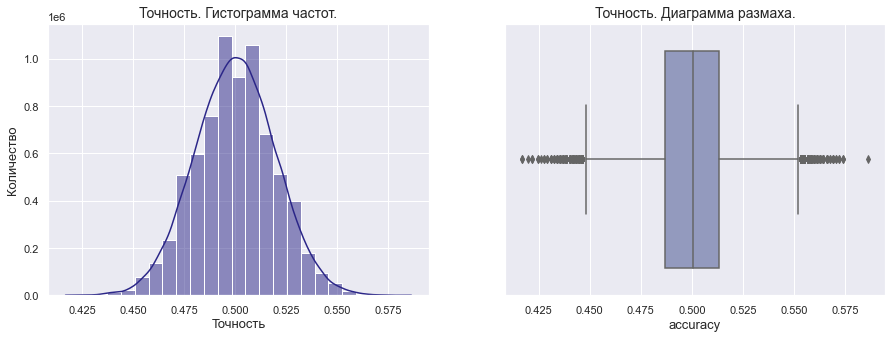

In [35]:
# построение гистограммы частот и диаграммы расмаха для значений точности, полученных на сгенерированных данных
pair_chart(pd.DataFrame(accuracy).rename(columns={0:'accuracy'})['accuracy'], 'accuracy')

На графиках получена идеальная форма Гауссовского распределения, с медианой и средним точно на значении `0.5`, что подтверждает случайность данных.

Сведём все полученные значения точности `accuracy` для различных алгоритмов для их наглядного сравнения.

In [36]:
# создание сводной таблицы для точности различных алгоритмов
df_res = pd.DataFrame(
    [[dt_result, rf_result, reg_result, dum_result, best_rnd_result]], 
    columns=['decision_tree', 'random_forest', 'logistic_regression', 'dummy', 'fully_random']
).T.rename(columns={0:'accuracy'}).sort_values(by='accuracy', ascending=False)

# просмотр полученной сводной таблицы с точностью для различных алгоритмов отсортированной по убыванию
display(df_res)

,accuracy
random_forest,0.816485
decision_tree,0.786936
logistic_regression,0.751166
dummy,0.699844
fully_random,0.586314


Для наглядной визуализации и графического сравнения точности (accuracy) различных моделей построим столбчатую диаграмму.

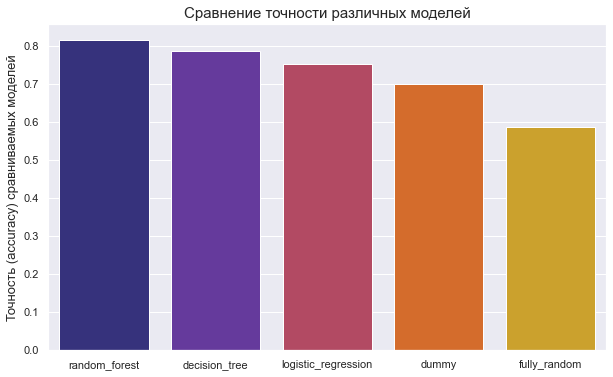

In [37]:
# построение столбчатой диаграммы для значений точности различных моделей
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_res, x=df_res.index, y='accuracy')
ax.set_title('Сравнение точности различных моделей', fontsize = 15)
ax.set_ylabel('Точность (accuracy) сравниваемых моделей', fontsize = 13)
plt.show();

* Точность простейшего алгоритма, равная `0.7` оказалась ниже всех рассмотренных ранее алгоритмов: решающего дерева, случайного леса и логистической регрессии.
* Для лучшей модели из случайных точность оставила `0.59`, то есть ещё ниже, чем для лучшего простейшего алгоритма.
* Идеальная колоколообразная форма распределения точности случайных моделей со средним и медианой на значении `0.5` подтвердила полную случаность значений точности для случайных моделей.

### Вывод по проверке моделей на вменяемость

* Самая лучшая модель на основе простейшего алгоритма, которую можно рассматривать как базовую, продемонстрировала более низкое значение точности `accuracy`, равное `0.7`, чем модель логистичкской регрессии, которая продемонстрировала худший по точности результат, равный `0.75`.
* Лучшая модель из случайных, точность которых была рассчитана для случайно сгенерированных значений целевого признака, продемонстрировала значение `accuracy`, равное `0.59`, то есть более чем на `10%` худший результат, чем лучший простейший алгоритм на основе *DummyClassifier()*.
* Из вышесказанного можно заключить, что все обученные модели (решающее дерево, случайный лес и логистическая регрессия) работают адекватно.

## Общие выводы

1. Полученные в файлe `users_behavior.csv` данные о поведении клиентов были успешно загружены и проанализированы. В полученных данных содержатся `3214` записей. Пропусков, дубликатов, нарушений стиля заголовков не обнаружено. Установлена необходимость незначаительной предобработки данных в виде изменения типа данных для количества звонков и сообщений.


2. Типы данных преобразованы в соотвествии с хранимой информацией. Изучены все количественные данные. Отмечено небольшое смещение данных вправо и наличие выбросов, которые для различных данных составили от `1.9` до `2.83%`. Выброс оставлены как есть. Подсчитано распределение классов целевой переменной в исследуемой выборке и установлено, что `класс 0` (тарифный план `«Смарт»`) представлен `69.4%` данных, а `класс 1` (тарифный план `«Ультра»`) - `30.6%` данных из чего сделан вывод о сбалансированности исследуемой выборки.


3. Были проанализированы различные модели с помощью которых была произведена попытка решения задачи бинарной классификации:
    * решающее дерево;
    * случайный лес;
    * логистическая регрессия.
    
    Все модели были обучены на решение задачи с подстройкой гиперпараметров  для достижения лучшей точности `accuracy`. Наилучшей точности, равной `0.816`, на тестовой выборке удалось достичь для модели случайного леса.
   
    
4. Произведена оценка моделей на вменяемость методом сравнения их точности с точностью простейшего классификатора.
    * Самая лучшая модель простейшего алгоритма, полученного после подстройки гиперпараметров, продемонстрировала более низкую точность - `0.7` по сравнению с наиболее слабой из обученных моделей, которой стала логистическая регрессия со значением точности, равным `0.75`.
    * Самая лучшая модель из случайных, полученных на случайно сгенерированных значениях целевого признака, обеспечила значение точности, равное `0.59`, что значительно меньше даже по сравнению с моделью простейшего алгоритма.
    * Из предыдущих двух подпунктов следует вывод, что все обученные модели (решающее дерево, случайный лес, логистическая регрессия) работают адекватно.


5. Все обученные модели (решающее дерево, случайный лес и логистическая регрессия) обеспечили значение точности `accuracy` удовлетворяющее условию задания.
    * Максимального значения `accuracy`, равного `0.816`, удалось достичь для модели случайного леса. Самую низкую точность, равную `0.751`, показала логистическая регрессия. Eё точность находится как раз на нижней границе требования к заданию.